 # NER MODEL - RoBERTa

## Imports

In [3]:
# ! pip install transformers
# ! pip install datasets
# ! pip install evaluate
# ! pip install seqeval

In [4]:
import json
import os
import numpy as np
import pandas as pd
import datasets
import transformers
import evaluate
import seqeval
import tensorflow as tf
import regex as re
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from google.colab import runtime

Mounted at /content/drive


## Data Preparation

In [5]:
datasetFolderPath = "/content/drive/MyDrive/ColabNotebooks/ScoreIT/Dataset/"
jsonFilePath = datasetFolderPath + "ResumeDataset.json"
csvFilePath = datasetFolderPath + "ResumeDataset.csv"
labelEncoderDecoderPath = datasetFolderPath + "LabelEncoderDecoder.json"

In [6]:
labelEncoderDecoder = json.load(open(labelEncoderDecoderPath))
labelEncoder = labelEncoderDecoder['labelEncoder']
labelDecoder = labelEncoderDecoder['labelDecoder']
labelDecoder = {int(k): v for k, v in labelDecoder.items()}

In [7]:
len(labelEncoder), len(labelDecoder)

(73, 73)

In [8]:
dataset = datasets.Dataset.from_json(jsonFilePath)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'text', 'annotations', 'input', 'NER_LABELS', 'NER_TAGS'],
    num_rows: 224
})

In [9]:
modelID = 'roberta-base'
tokenizer = transformers.RobertaTokenizerFast.from_pretrained(modelID, add_prefix_space=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [10]:
def alignLabelsWithTokens(labels, word_ids):
    newLabels = []
    currentWord = None
    for wordID in word_ids:
        if wordID is None:
            newLabels.append(-100)
        elif wordID != currentWord: # New Word
            currentWord = wordID
            newLabels.append(labels[wordID])
        else: # Same Word
            label = labels[wordID]
            newLabels.append(label)
    return newLabels

In [11]:
def tokenizerFunction(dataset):
    tokenized = tokenizer(dataset['input'], truncation=True, is_split_into_words=True, max_length=512, padding='max_length')
    tokenized['labels'] =  alignLabelsWithTokens(dataset['NER_TAGS'], tokenized.word_ids())
    return tokenized

In [12]:
tokenizedDataset = dataset.map(tokenizerFunction, remove_columns=['id', 'input', 'NER_LABELS', 'NER_TAGS', 'text', 'annotations'])

Map:   0%|          | 0/224 [00:00<?, ? examples/s]

In [13]:
tokenizedDataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 224
})

In [14]:
dataCollator = transformers.DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors='tf')

In [15]:
BATCH_SIZE = 4

In [16]:
tfDataset = tokenizedDataset.to_tf_dataset(
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=dataCollator,
)

In [17]:
trainDataset = tfDataset.take(int(len(tfDataset) * 0.9))
remDataset = tfDataset.skip(int(len(tfDataset) * 0.9))
valDataset = remDataset.take(int(len(remDataset) * 0.5))
testDataset = remDataset.skip(int(len(remDataset) * 0.5))

In [18]:
len(trainDataset), len(valDataset), len(testDataset)

(50, 3, 3)

## Modeling

In [20]:
modelID = 'roberta-base'
model = transformers.TFAutoModelForTokenClassification.from_pretrained(modelID, num_labels=73)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForTokenClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model.summary()

Model: "tf_roberta_for_token_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  56137     
                                                                 
Total params: 124111177 (473.45 MB)
Trainable params: 124111177 (473.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

In [22]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [23]:
learningRateScheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [24]:
NUM_EPOCHS = 200
batchesPerEpoch = len(tokenizedDataset) // BATCH_SIZE
totalTrainSteps = batchesPerEpoch * NUM_EPOCHS
optimizer, schedule = transformers.create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=totalTrainSteps)

In [25]:
model.compile(optimizer=optimizer, metrics=['accuracy'])

In [26]:
history = model.fit(
    trainDataset,
    validation_data=valDataset,
    epochs=NUM_EPOCHS,
    callbacks=[earlyStopping, learningRateScheduler]
)

Epoch 1/200
50/50 [==============================] - 59s 318ms/step - loss: 2.6046 - accuracy: 0.3844 - val_loss: 2.4035 - val_accuracy: 0.3571 - lr: 1.9913e-05
Epoch 2/200
50/50 [==============================] - 11s 227ms/step - loss: 2.2865 - accuracy: 0.3949 - val_loss: 2.0913 - val_accuracy: 0.3901 - lr: 1.9823e-05
Epoch 3/200
50/50 [==============================] - 11s 229ms/step - loss: 2.0948 - accuracy: 0.3958 - val_loss: 1.8919 - val_accuracy: 0.3776 - lr: 1.9734e-05
Epoch 4/200
50/50 [==============================] - 11s 228ms/step - loss: 1.8017 - accuracy: 0.4147 - val_loss: 1.5715 - val_accuracy: 0.5000 - lr: 1.9645e-05
Epoch 5/200
50/50 [==============================] - 11s 223ms/step - loss: 1.6048 - accuracy: 0.4361 - val_loss: 1.3299 - val_accuracy: 0.3970 - lr: 1.9555e-05
Epoch 6/200
50/50 [==============================] - 11s 224ms/step - loss: 1.4874 - accuracy: 0.4422 - val_loss: 1.2800 - val_accuracy: 0.5312 - lr: 1.9466e-05
Epoch 7/200
50/50 [===============

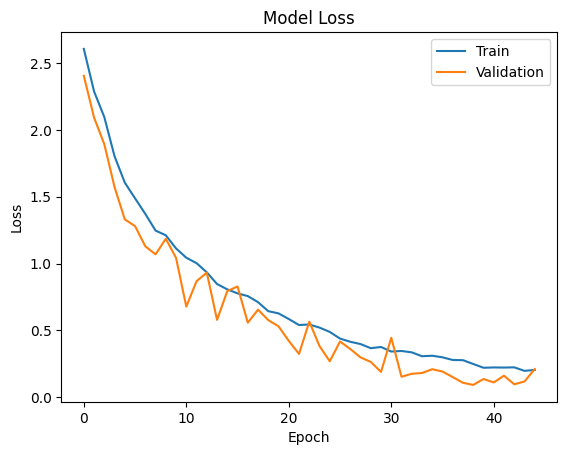

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

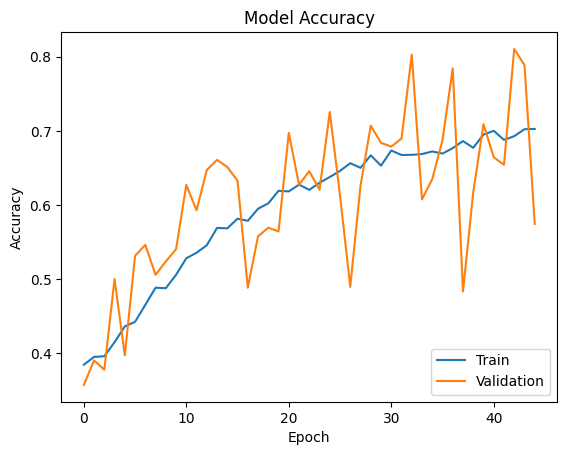

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

In [29]:
modelFolderPath = "/content/drive/MyDrive/ColabNotebooks/ScoreIT/Models/"
model.save_pretrained(modelFolderPath + "ResumeNERModel-RoBERTaBase")

## Testing

In [30]:
modelID = 'roberta-base'
modelFolderPath = "/content/drive/MyDrive/ColabNotebooks/ScoreIT/Models/"
modelPath = modelFolderPath + "ResumeNERModel-RoBERTaBase"
tokenizer = transformers.RobertaTokenizerFast.from_pretrained(modelID, add_prefix_space=True)
model = transformers.TFAutoModelForTokenClassification.from_pretrained(modelPath)

Some layers from the model checkpoint at /content/drive/MyDrive/ColabNotebooks/ScoreIT/Models/ResumeNERModel-RoBERTaBase were not used when initializing TFRobertaForTokenClassification: ['dropout_75']
- This IS expected if you are initializing TFRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaForTokenClassification were initialized from the model checkpoint at /content/drive/MyDrive/ColabNotebooks/ScoreIT/Models/ResumeNERModel-RoBERTaBase.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForTokenClassifi

In [31]:
def extract_tokens_from_resume(text):
    if isinstance(text, list):
        return
    # Remove non-breaking spaces and normalize
    text = text.replace("\xa0", " ").strip()

    # Split on words, numbers, and punctuation
    tokens = re.findall(r'\w+|[^\w\s]', text, re.UNICODE)
    return tokens

In [32]:
def getClasses(labelEncoder):
    classes = set()
    classes.add('O')
    for label in labelEncoder.keys():
        if label == 'O':
            continue
        l = label[2:]
        classes.add(l)
    classes = list(classes)
    return classes

In [33]:
def getResults(inputText, predictions, labelEncoderDecoder):
    labelEncoder = labelEncoderDecoder['labelEncoder']
    labelDecoder = labelEncoderDecoder['labelDecoder']
    labelDecoder = {int(k): v for k, v in labelDecoder.items()}
    classes = getClasses(labelEncoder)
    results = {}
    for label in classes:
        results[label] = ""
    for i, pred in enumerate(predictions):
        pred = labelDecoder[pred]
        if pred == 'O':
            results['O'] += tokenizer.decode(inputText['input_ids'][0][i])
        else:
            prefix = pred[0]
            pred = pred[2:]
            if prefix == 'I':
                results[pred] += tokenizer.decode(inputText['input_ids'][0][i])
            else:
                results[pred] = '\n'
                results[pred] = tokenizer.decode(inputText['input_ids'][0][i])
    return results

In [34]:
def infer(text, modelID, modelPath, labelEncoderDecoder):
    tokenizer = transformers.RobertaTokenizerFast.from_pretrained(modelID, add_prefix_space=True)
    model = transformers.TFAutoModelForTokenClassification.from_pretrained(modelPath)

    if isinstance(text, str):
        text = text.split(" ")
    inputText = tokenizer(text, is_split_into_words=True, truncation=True, padding='max_length', max_length=512, return_tensors='tf')

    predictions = model(**inputText).logits
    predictions = tf.argmax(predictions, axis=2).numpy()
    predictions = np.squeeze(predictions)

    results = getResults(inputText, predictions, labelEncoderDecoder)
    return results

In [35]:
def postprocess_resume_ner_output(raw_output):
    processed = {}
    multi_value_fields = {
        'designation', 'company_name', 'technical_skills',
        'soft-skills', 'work_year', 'achievement', 'certification',
        'work_cities', 'languages_known'
    }
    for label, value in raw_output.items():
        if not value or value.strip() == "":
            continue

        # Remove any stray special tokens or junk characters
        cleaned = value.replace("<s>", "").replace("</s>", "").replace("<pad>", "").strip()

        # Remove excessive whitespace and punctuation artifacts
        cleaned = " ".join(cleaned.split())
        cleaned = cleaned.replace(" .", ".").replace(" ,", ",").replace(" :", ":").replace(" %", "%")

        # Remove duplicate adjacent words
        cleaned = re.sub(r'\b(\w+)( \1\b)+', r'\1', cleaned)

        # Remove excess punctuation and fix spacing
        cleaned = re.sub(r'\s+', ' ', cleaned)
        cleaned = re.sub(r'[\-\–\—]{2,}', '-', cleaned)
        cleaned = re.sub(r'([,:;])\1+', r'\1', cleaned)

        processed[label] = cleaned

    return processed

In [36]:
randomIndex = np.random.randint(1, 10)
randomIndex *= -1
testRecord = dataset[randomIndex]
testInput = testRecord['text']
testTokens = extract_tokens_from_resume(testInput)
len(testTokens)

192

In [37]:
result = infer(testTokens, modelID, modelPath, labelEncoderDecoder)
result = postprocess_resume_ner_output(result)

Some layers from the model checkpoint at /content/drive/MyDrive/ColabNotebooks/ScoreIT/Models/ResumeNERModel-RoBERTaBase were not used when initializing TFRobertaForTokenClassification: ['dropout_75']
- This IS expected if you are initializing TFRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaForTokenClassification were initialized from the model checkpoint at /content/drive/MyDrive/ColabNotebooks/ScoreIT/Models/ResumeNERModel-RoBERTaBase.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForTokenClassifi

In [38]:
for key, value in result.items():
  if value == '':
    continue
  print(f"{key}: {value}")

technical_skills: VMware
planning: Design and implement availabilityscalability and performance plans for the managed service in Google Cloud Architected
initiating_actions: ivered
work_cities: Bengal
O: GCPAzureAWS Accomplished Architect with of IT professional expertise with of experience on and experienced with migration of on premises to Cloud systems Work ExperienceGCPuru Karnataka and components were BigQueryCloud StorageData FusionCloud Composer Cloud Dataflow HardwareSoftware Network and Security Guided the team on using these tools and helping in deployments Education 2002 Skills IT Skills Ticketing Tools Service Now JIRA GCPRecommenderCompute EngineCloud Data FusionCloud ComposerBigQueryDatastoreCloud Deployment ManagerCloud Build Cloud FunctionsCloud IdentityCloud Load BalancingCloud Asset InventorySecurity Command CenterCloud StorageVirtual Private Cloud VPC 2 years AzureAdvisorVirtual MachinesData FactorySynapse AnalyticsCosmos DBDeployment ManagerDevOpsFunctions Serverles

## Evaluation

In [39]:
metric = evaluate.load('seqeval')

In [40]:
allPreds = []
allLabels = []

In [41]:
for batch in testDataset:
    logits = model.predict(batch)['logits']
    labels = batch['labels'].numpy()
    predictions = tf.argmax(logits, axis=-1).numpy()
    batchPred = []
    batchLabels = []
    for i in range(len(predictions)):
        for j in range(len(predictions[i])):
            if labels[i][j] != -100:
                batchPred.append(labelDecoder[predictions[i][j]])
                batchLabels.append(labelDecoder[labels[i][j]])
    allPreds.append(batchPred)
    allLabels.append(batchLabels)

1/1 [==============================] - 0s 72ms/step


In [42]:
metric.compute(predictions=allPreds, references=allLabels)

{'achievement': {'precision': np.float64(0.6428571428571429),
  'recall': np.float64(0.42857142857142855),
  'f1': np.float64(0.5142857142857143),
  'number': np.int64(21)},
 'adaption_to_change': {'precision': np.float64(0.75),
  'recall': np.float64(0.6428571428571429),
  'f1': np.float64(0.6923076923076924),
  'number': np.int64(14)},
 'analyzing': {'precision': np.float64(1.0),
  'recall': np.float64(1.0),
  'f1': np.float64(1.0),
  'number': np.int64(2)},
 'applying_expertise': {'precision': np.float64(0.7657657657657657),
  'recall': np.float64(0.8018867924528302),
  'f1': np.float64(0.783410138248848),
  'number': np.int64(106)},
 'basic_education': {'precision': np.float64(0.8571428571428571),
  'recall': np.float64(0.8571428571428571),
  'f1': np.float64(0.8571428571428571),
  'number': np.int64(14)},
 'birth_date': {'precision': np.float64(0.9230769230769231),
  'recall': np.float64(0.8571428571428571),
  'f1': np.float64(0.888888888888889),
  'number': np.int64(14)},
 'candi

In [ ]:
runtime.unassign()